# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.293693,True,5.673256
1,1.154247,True,6.413727
2,0.529595,False,-0.148893
3,0.606265,False,1.595630
4,0.184912,False,1.077174
...,...,...,...
995,-1.029028,False,-0.412245
996,2.075526,True,5.441286
997,0.438079,False,-0.500129
998,0.727236,True,5.653554


<Axes: xlabel='v0'>

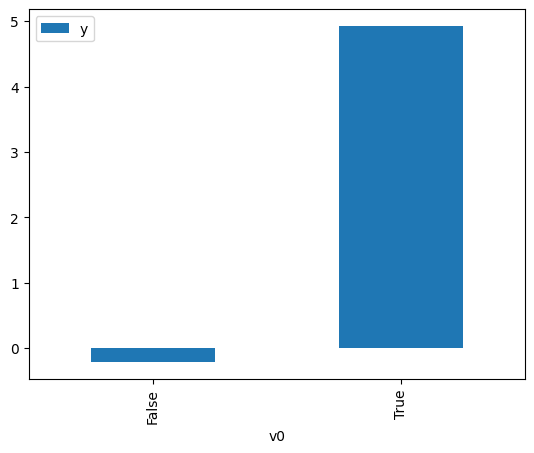

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

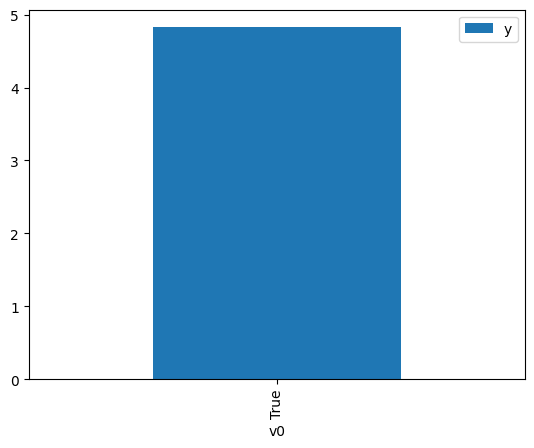

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.574669,False,-0.254979,0.036696,27.250641
1,-1.660008,False,-0.317410,0.963977,1.037369
2,-0.483898,False,0.474322,0.711710,1.405067
3,-0.205005,False,0.355425,0.583842,1.712792
4,1.545657,False,0.571663,0.038832,25.751873
...,...,...,...,...,...
995,1.545657,False,0.571663,0.038832,25.751873
996,-1.697620,False,-1.420249,0.966532,1.034626
997,-0.430249,False,1.301478,0.688902,1.451585
998,-1.098419,False,-2.373795,0.895570,1.116607


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.176755,True,5.747377,0.607071,1.647254
1,-0.665073,True,5.827062,0.219116,4.563803
2,0.482808,True,4.917149,0.741770,1.348126
3,0.903632,True,5.114241,0.870786,1.148387
4,0.031173,True,4.524439,0.534946,1.869346
...,...,...,...,...,...
995,-1.035498,True,4.003942,0.116970,8.549206
996,-0.756735,True,2.983293,0.188993,5.291214
997,1.676292,True,4.382391,0.969928,1.031005
998,0.922631,True,6.197707,0.875057,1.142783


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.925
Model:                            OLS   Adj. R-squared (uncentered):              0.925
Method:                 Least Squares   F-statistic:                              6180.
Date:                Mon, 04 Nov 2024   Prob (F-statistic):                        0.00
Time:                        16:47:19   Log-Likelihood:                         -1401.6
No. Observations:                1000   AIC:                                      2807.
Df Residuals:                     998   BIC:                                      2817.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3960      0.033     12.128      0.000       0.332       0.460
x2             5.0179      0.049    103.137      0.000       4.922       5.113
==============================================================================
Omnibus:                        1.581   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.454   Jarque-Bera (JB):                1.517
Skew:                           0.019   Prob(JB):                        0.468
Kurtosis:                       3.187   Cond. No.                         1.63
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""